## 不均衡学习

produced by 梅子行

### 数据不平衡

在很多真实场景下，数据集往往是不平衡的。也就是说，在数据集中，有一类含有的数据要远远多于其他类的数据（类别分布不平衡）。在贷款场景下，我们主要介绍二分类中的类别不平衡问题。  

常识告诉我们一家信用正常客户的数据要远远多于欺诈客户的。  

考虑一个简单的例子，10万正样本（正常客户标签为0）与1000个负样本（欺诈客户标签为1），正负样本比列为100：1，如果直接带入模型中去学习，每一次梯度下降如果使用全量样本，负样本的权重只有不到1/100，即使完全不学习负样本的信息，准确率也有超过99%，所以显然我们绝不能以准确率来衡量模型的效果。但是实践下面，我们其实也知道，即使用KS或者AUC来度量模型的表现，依然没法保证模型能将负样本很好的学习。而我们实际上需要得到一个分类器，既能对于正例有很高的准确率，同时又不会影响到负例的准确率。

类似于上面例子中的数据集，由于整个数据空间中，正例和负例的数据就是不平衡的。因此，这样的不平衡数据集的产生往往是内在的。同时，也有很多其他的因素会造成数据的不平衡，例如，时间，存储等。由于这些原因产生不平衡的数据集往往被称为外在的。除了数据集的内在和外在，我们可能还要注意到数据集的相对不平衡以及绝对不平衡。假设上述例子中的数据集有100000条数据，负例和正例的比例为100:1，只包含1000个正例。明显的，我们不能说1000个数据就是绝对小的，只不过相对于负例来说，它的数量相对较少。因此，这样的数据集被认为是相对不平衡的。

### 解决方法

* 下探
* 半监督学习
* 标签分裂
* 代价敏感
* 采样算法

### 下探

最直接解决风控场景样本不均衡的方法。

所谓下探，就是对评分较低被拒绝的人进行放款，牺牲一部分收益，来积累坏样本，供后续模型学习。  
这也是所有方法中最直接有效的。但是不是每一家公司都愿意承担这部分坏账。

此外我们之前提到过，随着业务开展，后续模型迭代的时候，使用的样本是有偏的，下探同样可以解决这个问题。

### 半监督学习

将被拒绝客户的数据通过半监督的方法逐渐生成标签，然后带入模型中进行训练。比较典型分方法有拒绝演绎、暴力半监督等等。

#### 1）拒绝演绎

拒绝演绎或者叫拒绝推断，是一种根据经验对低分客户进行百分比采样的方法。  
比如最低分的客群百分之五十视为坏人，其次百分之四十等等。   
效果没有下探好。但不用额外有任何开销。  
参考资料：群内预习资料中的《信用风险评分卡研究》第十三章。  

#### 2）暴力半监督

比较粗暴的做法是将样本的每一种标签方式进行穷举，带入模型看对模型是否有帮助，效率较低，容易过拟合。

#### 3）模型筛选

用训练过的其他模型对无标签样本打标签，然后模型进行训练。很多公司会用当前模型在上面做预测，然后带入模型继续训练。很不推荐这样做，效果一般是很差的。可以考虑无监督算法或者用很旧的样本做训练然后做预测。

#### 等等...

### 标签分裂

我们有时候会不止使用传统的逾期或者rollrate来定义好坏。而是通过一些聚类手段对数据进行切分，然后分别在自己的样本空间内单独学习。基于模型的比如kmeans，分层聚类等等。基于经验的比如将失联客户、欺诈客户拆开，单独建模。

为什么要这样做呢？我们看一个例子。

小明生了慢粒白血病，她的失散多年的哥哥找到有2家比较好的医院，医院A和医院B供小明选择就医。

小明的哥哥多方打听，搜集了这两家医院的统计数据，它们是这样的：

医院A最近接收的1000个病人里，有900个活着，100个死了。

医院B最近接收的1000个病人里，有800个活着，200个死了。

作为对统计学懵懵懂懂的普通人来说，看起来最明智的选择应该是医院A对吧，病人存活率很高有90%啊！总不可能选医院B吧，存活率只有80%啊。

呵呵，如果小明的选择是医院A，那么她就中计了。

就这么说吧，如果医院A最近接收的1000个病人里，有100个病人病情很严重，900个病人病情并不严重。

在这100个病情严重的病人里，有30个活下来了，其他70人死了。所以病重的病人在医院A的存活率是30%。

而在病情不严重的900个病人里，870个活着，30个人死了。所以病情不严重的病人在医院A的存活率是96.7%。

在医院B最近接收的1000个病人里，有400个病情很严重，其中210个人存活，因此病重的病人在医院B的存活率是52.5%。

有600个病人病情不严重，590个人存活，所以病情不严重的病人在医院B的存活率是98.3%。


画成表格，就是这样的——

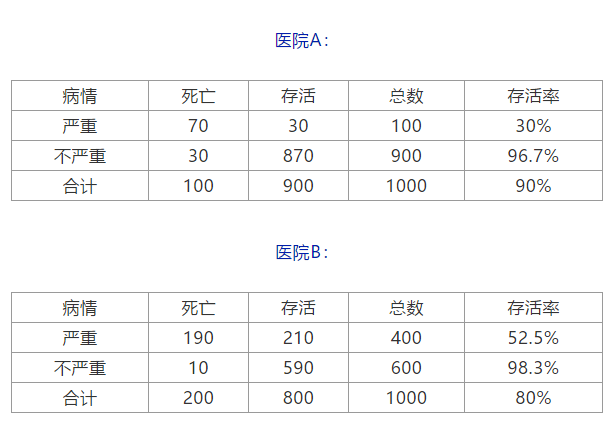

In [2]:
from IPython.display import Image
Image(filename='1.png', width=600) 

你可以看到，在区分了病情严重和不严重的病人后，不管怎么看，最好的选择都是医院B。但是只看整体的存活率，医院A反而是更好的选择了。所谓远看是汪峰，近看白岩松，就是这个道理。

实际上，我们刚刚看到的例子，就是统计学中著名的黑魔法之一——辛普森悖论（Simpson's paradox）。辛普森悖论就是当你把数据拆开细看的时候，细节和整体趋势完全不同的现象。


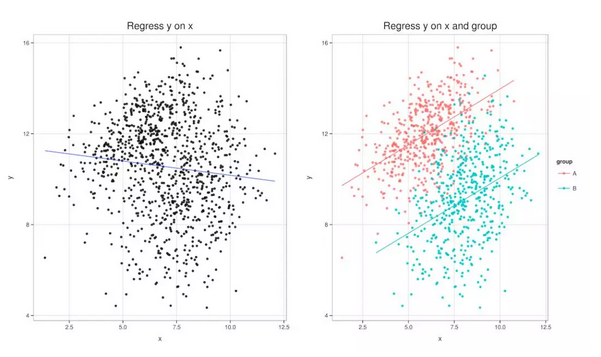

In [3]:
from IPython.display import Image
Image(filename='2.png', width=600) 

### 代价敏感学习

代价敏感学习则是利用不同类别的样本被误分类而产生不同的代价，使用这种方法解决数据不平衡问题。而且有很多研究表明，代价敏感学习和样本不平衡问题有很强的联系，并且使用代价敏感学习的方法解决不平衡学习问题要优于使用随机采样的方法。

1) 把误分类代价作为数据集的权重，然后采用 Bootstrap 采样方法选择具有最好的数据分布的数据集；  
2) 以集成学习的模式来实现代价最小化的技术，这种方法可以选择很多标准的学习算法作为集成学习中的弱分类器；  
3) 把代价敏感函数或者特征直接合并到分类器的参数中，这样可以更好的拟合代价敏感函数。由于这类技术往往都具有特定的参数，因此这类方法没有统一的框架；


### 采样算法

今天我们涉及的主要是过采样方法

* 朴素随机过采样
* SMOTE
* ADASYN

#### 朴素随机过采样

In [4]:
from sklearn.datasets import make_classification
from collections import Counter
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.99],
                           class_sep=0.8, random_state=0)
Counter(y)

Counter({1: 4923, 0: 77})

In [5]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X, y)


sorted(Counter(y_resampled).items())

[(0, 4923), (1, 4923)]

#### SMOTE

SMOTE: 对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本；  

但是，SMOTE容易出现过泛化和高方差的问题，而且，容易制造出重叠的数据。

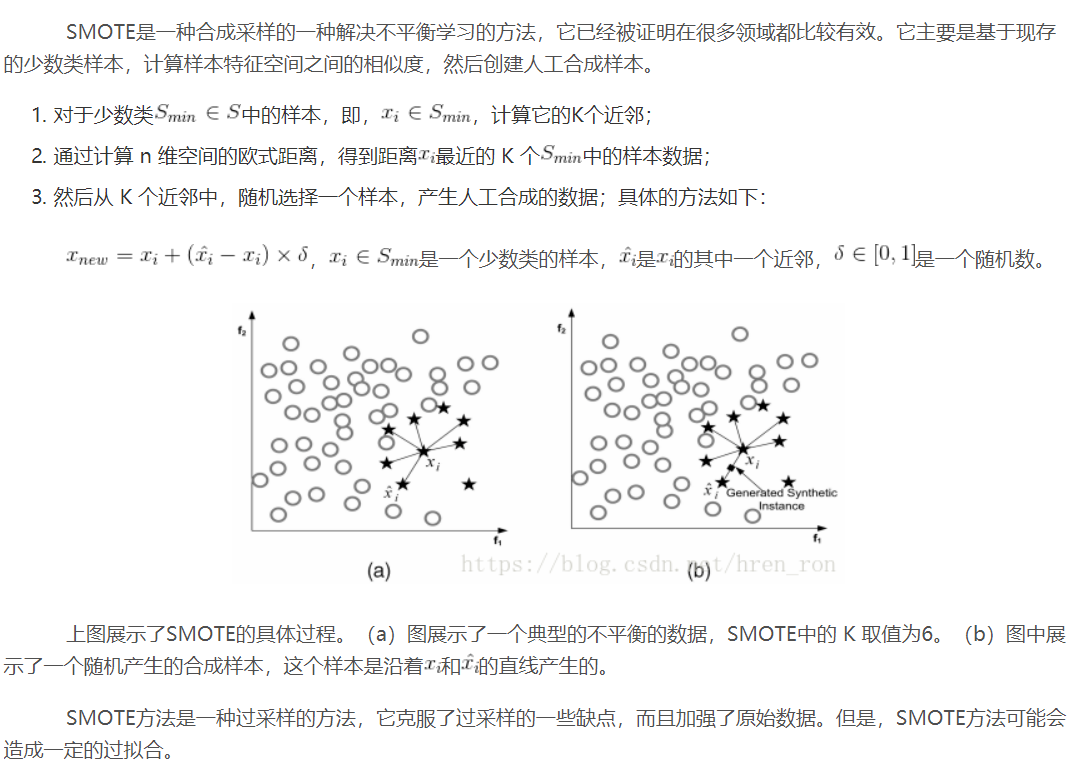

In [10]:
Image(filename='3.jpg', width=800) 

为了克服SMOTE的缺点，Adaptive Synthetic Sampling方法被提出，主要包括：Borderline-SMOTE和Adaptive Synthetic Sampling（ADA-SYN）算法。  

Borderline-SMOTE：对靠近边界的minority样本创造新数据。其与SMOTE的不同是：SMOTE是对每一个minority样本产生综合新样本，而Borderline-SMOTE仅对靠近边界的minority样本创造新数据。如下图，只对A中的部分数据进行操作： 


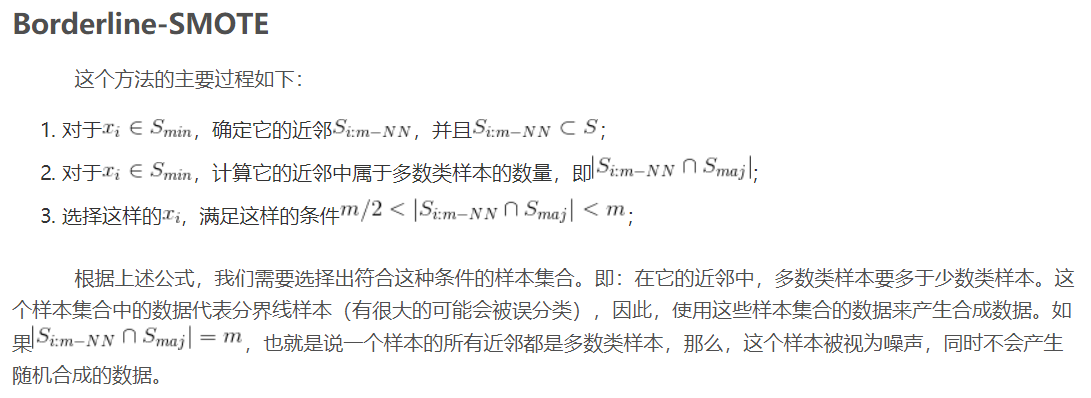

In [16]:
Image(filename='5.png', width=800) 

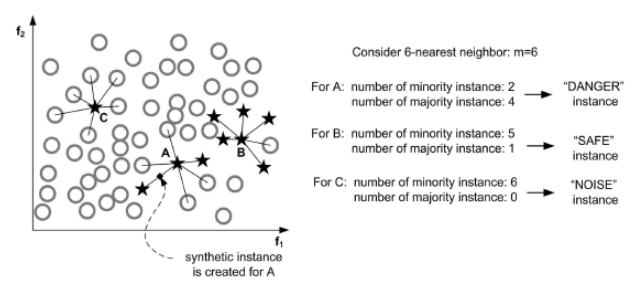

In [15]:
Image(filename='4.png', width=500) 

这个图中展示了该方法的实现过程，我们可以发现和SMOTE方法的不同之处：  

SMOTE对于每一个少数类样本都会产生合成样本，但是Borderline-SMOTE只会对邻近边界的少数类样本生成合成数据。

ADA-SYN：根据majority和minority的密度分布，动态改变权重，决定要generate多少minority的新数据。

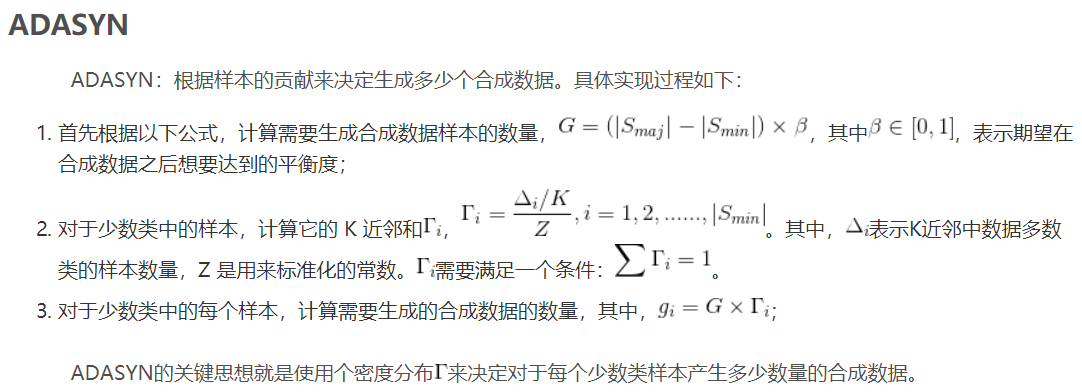

In [18]:
Image(filename='6.png', width=800) 

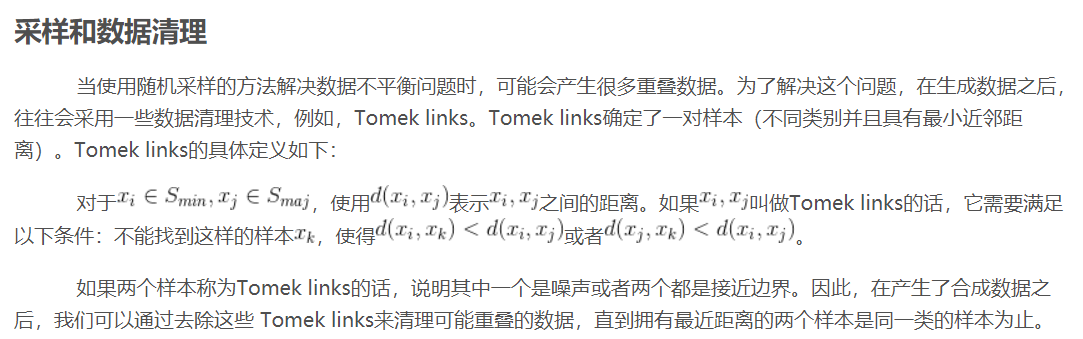

In [19]:
Image(filename='7.png', width=800) 

基于聚类的随机采样（CBO）
基于聚类的随机采样方法可以用来解决类内不平衡问题，主要利用的聚类的方法。具体的过程如下：  

随机选择K个样本作为K个簇，并且计算K类样本在特征空间的平均值，作为聚类中心；  
对于剩下的每一个样本，计算它和K个聚类中心的欧氏距离，根据欧式聚类将其分配到最近的类簇中；  
更新每个簇的聚类中心，直到所有的样本都用完；  

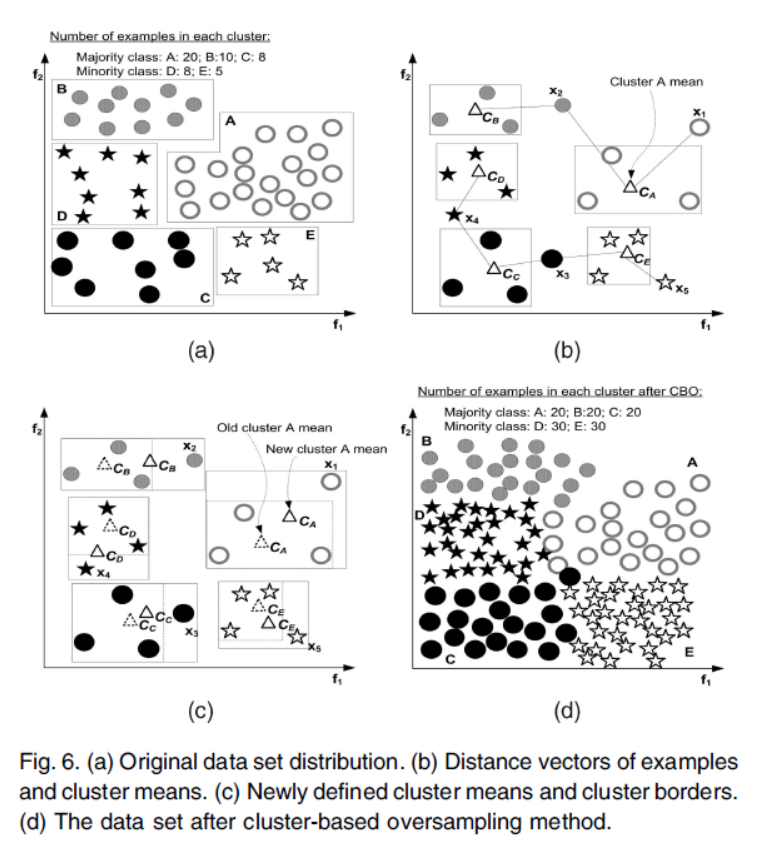

In [24]:
Image(filename='9.png', width=500) 

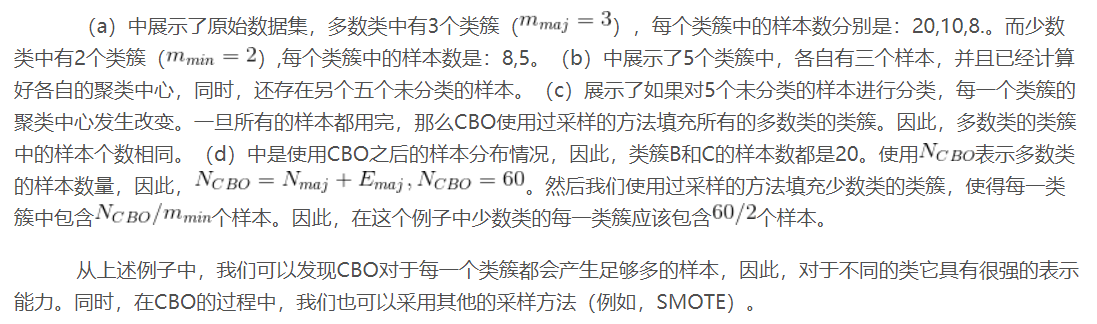

In [21]:
Image(filename='8.png', width=800) 

采样方法和集成方法的集成
目前已经有很多的方法把随机采样和集成学习的方法集成在一起，下面介绍两种这样的方法：

* SMOTEBoost  
* DataBoost-IM  

#### SMOTEBoost
SMOTEBoost主要是把SMOTE和AdaBoost.M2集成在一起，SMOTEBoost方法在每次Boost迭代过程中使用合成数据的方法。因此，每一次迭代过程中的分类器都会集中到更多的少数类样本。

#### DataBoost-IM
DataBoost-IM主要是把数据生成技术和AdaBoost.M1方法结合在一起，主要根据不同类之间样本的很难被学习到的比例。具体过程主要是如下：

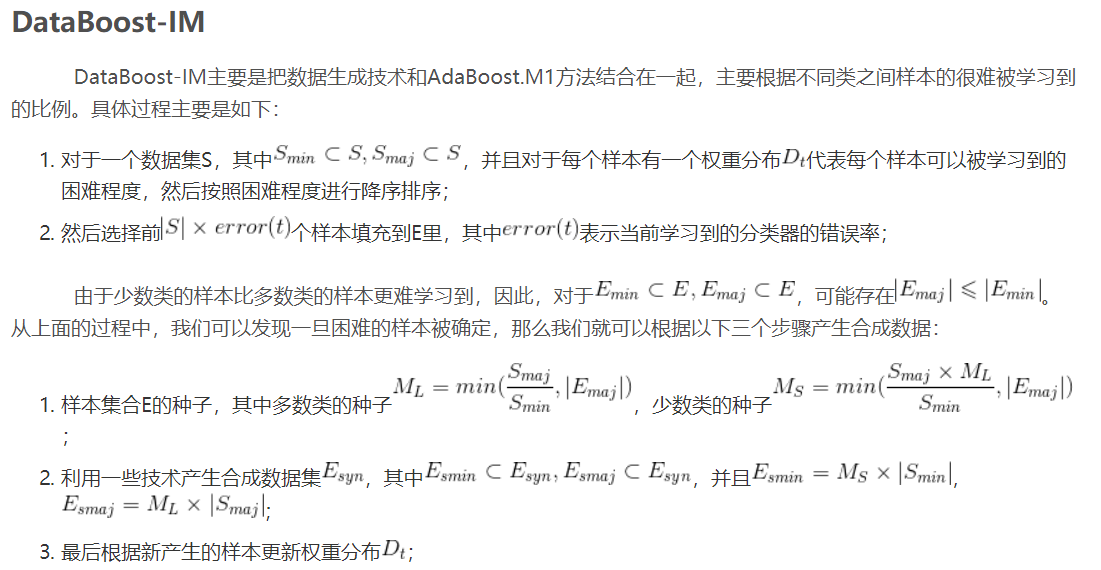

In [25]:
Image(filename='10.png', width=800) 

In [7]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(X, y)

sorted(Counter(y_resampled_smote).items())

[(0, 4923), (1, 4923)]

In [8]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(X, y)

sorted(Counter(y_resampled_adasyn).items())

[(0, 4935), (1, 4923)]

相对于基本的SMOTE算法, 关注的是所有的少数类样本, 这些情况可能会导致产生次优的决策函数。  
因此SMOTE就产生了一些变体，这些方法关注在最优化决策函数边界的一些少数类样本, 然后在最近邻类的相反方向生成样本。、
SMOTE函数中的kind参数控制了选择哪种变体
* regular
* borderline1
* borderline2
* svm

In [10]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(kind='borderline1').fit_sample(X, y)

sorted(Counter(y_resampled).items())

[(0, 4923), (1, 4923)]

接下来我们启用上一节课的例子

In [65]:
import glob
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.neighbors import KNeighborsClassifier 
data = pd.read_csv('Acard.txt')
data.head()

,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


In [14]:
data.obs_mth.unique()

array(['2018-10-31', '2018-07-31', '2018-09-30', '2018-06-30',
       '2018-11-30'], dtype=object)

In [68]:
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
evl = data[data.obs_mth == '2018-11-30'].reset_index().copy()

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_ks :  0.4482453222991063
evl_ks :  0.4198642457760936


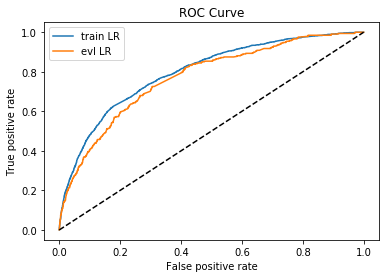

In [69]:
x = train[feature_lst]
y = train['bad_ind']

evl_x =  evl[feature_lst]
evl_y = evl['bad_ind']

lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)

y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(evl_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(evl_y,y_pred)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

接下来先用lgb做预测，然后做前融合。  
相比于不修改损失函数的xgb，lgb的优势只是比较快。  

这里的思想类似于对训练样本做异常点检测，  
只不过不是根据数据内部分布差异，而是使用精准度更高的集成模型，  
将难以辨认的样本，视为噪音。  
可以理解为大神都做不对的题目，就别给普通学员学了，可能会适得其反。  

首先做网格调参，给lgb找一组较好的参数  

In [70]:
train_x,test_x,train_y,test_y = train_test_split(x,y,random_state=0,test_size=0.4)

params = {
            'boosting_type':'gbdt',
            'objective':'binary',
            'metric':'auc',
            'nthread':4,
            'learning_rate':0.1,
            'num_leaves':30,
            'max_depth':5,
            'subsample':0.8,
            'colsample_bytree':0.8,
        }

data_train = lgb.Dataset(train_x,train_y)

cv_results = lgb.cv(params,
                    data_train,
                    num_boost_round = 1000,
                    nfold = 5,
                    stratified = False,
                    shuffle = True,
                    metrics = 'auc',
                    early_stopping_rounds = 100,
                    seed = 0
                    )
print('best n_estimators:',len(cv_results['auc-mean']))
print('best cv score:',pd.Series(cv_results['auc-mean']).max())

best n_estimators: 24
best cv score: 0.8097663177199287


In [71]:
def  lgb_test(train_x,train_y,test_x,test_y):
    clf =lgb.LGBMClassifier(boosting_type = 'gbdt',
                           objective = 'binary',
                           metric = 'auc',
                           learning_rate = 0.1,
                           n_estimators = 24,
                           max_depth = 4,
                           num_leaves = 25,
                           max_bin = 40,
                           min_data_in_leaf = 5,
                           bagging_fraction = 0.6,
                           bagging_freq = 0,
                           feature_fraction = 0.8,
                           )
    clf.fit(train_x,train_y,eval_set = [(train_x,train_y),(test_x,test_y)],eval_metric = 'auc')
    return clf,clf.best_score_['valid_1']['auc'],
lgb_model , lgb_auc  = lgb_test(train_x,train_y,test_x,test_y)
feature_importance = pd.DataFrame({'name':lgb_model.booster_.feature_name(),
                                   'importance':lgb_model.feature_importances_}).sort_values(by=['importance'],ascending=False)

pred = lgb_model.predict_proba(train_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(train_y,pred)
print(abs(fpr_lgb - tpr_lgb).max())
    
pred = lgb_model.predict_proba(test_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(test_y,pred)
print(abs(fpr_lgb - tpr_lgb).max())

pred = lgb_model.predict_proba(evl_x)[:,1]
fpr_lgb,tpr_lgb,_ = roc_curve(evl_y,pred)
print(abs(fpr_lgb - tpr_lgb).max())

[1]	training's auc: 0.764327	valid_1's auc: 0.74748
[2]	training's auc: 0.81104	valid_1's auc: 0.795364
[3]	training's auc: 0.815393	valid_1's auc: 0.801769
[4]	training's auc: 0.819752	valid_1's auc: 0.804643
[5]	training's auc: 0.819358	valid_1's auc: 0.805129
[6]	training's auc: 0.821207	valid_1's auc: 0.805297
[7]	training's auc: 0.821572	valid_1's auc: 0.804743
[8]	training's auc: 0.822117	valid_1's auc: 0.80607
[9]	training's auc: 0.822494	valid_1's auc: 0.806053
[10]	training's auc: 0.821979	valid_1's auc: 0.805704
[11]	training's auc: 0.821362	valid_1's auc: 0.805741
[12]	training's auc: 0.822991	valid_1's auc: 0.806829
[13]	training's auc: 0.824437	valid_1's auc: 0.807311
[14]	training's auc: 0.82526	valid_1's auc: 0.807217
[15]	training's auc: 0.826336	valid_1's auc: 0.807852
[16]	training's auc: 0.826902	valid_1's auc: 0.807857
[17]	training's auc: 0.827597	valid_1's auc: 0.80819
[18]	training's auc: 0.827992	valid_1's auc: 0.808283
[19]	training's auc: 0.828076	valid_1's au

粗略调参的lgb比lr无显著提升，下面进行权重调整。  
前后各取部分错分样本，减小权重，其余样本为1。  
虽然后面还会给予新的权重，但是这部分权重永远只有正常样本的固定比例。  

In [72]:
sample = x[feature_lst]
sample['bad_ind'] = y
sample['pred'] = lgb_model.predict_proba(x)[:,1]
sample = sample.sort_values(by=['pred'],ascending=False).reset_index()

sample['rank'] = np.array(sample.index)/75522

def weight(x,y):
    if x == 0 and y < 0.1:
        return 0.1
    elif x == 1 and y > 0.7:
        return 0.1
    else:
        return 1

sample['weight'] = sample.apply(lambda x: weight(x.bad_ind,x['rank']),axis = 1)

def lr_wt_predict(train_x,train_y,evl_x,evl_y,weight):
    lr_model = LogisticRegression(C=0.1,class_weight='balanced')
    lr_model.fit(train_x,train_y,sample_weight = weight )
    
    y_pred = lr_model.predict_proba(train_x)[:,1]
    fpr_lr,tpr_lr,_ = roc_curve(train_y,y_pred)
    train_ks = abs(fpr_lr - tpr_lr).max()
    print('train_ks : ',train_ks)
    
    y_pred = lr_model.predict_proba(evl_x)[:,1]
    fpr_lr,tpr_lr,_ = roc_curve(evl_y,y_pred)
    evl_ks = abs(fpr_lr - tpr_lr).max()
    print('evl_ks : ',evl_ks)
    
lr_wt_predict(sample[feature_lst],sample['bad_ind'],evl_x,evl_y,sample['weight'])

train_ks :  0.4602564513254416
evl_ks :  0.4289610959476374


C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


此时的lr，相比于最开始的lr，提升了1个百分点。  

这里省略了一些其他的探索，由于其他算法实验效果不理想，最终选取lgb作为筛选样本的工具。  

接下来考虑基于差值思想的过采样方法，增加一部分虚拟的负样本。  
这里需要注意，之前权重减小的样本是不应该用来做过采样的。  
所以将训练数据先拆分成两部分。weight=1的做过采样，其余的不变。  

In [73]:
osvp_sample = sample[sample.weight == 1].drop(['pred','index','weight'],axis = 1)
osnu_sample = sample[sample.weight < 1].drop(['pred','index',],axis = 1)

train_x_osvp = osvp_sample[feature_lst]
train_y_osvp = osvp_sample['bad_ind']

下面做基于borderline1的smote算法做过采样

In [75]:
def lr_predict(train_x,train_y,evl_x,evl_y):
    lr_model = LogisticRegression(C=0.1,class_weight='balanced')
    lr_model.fit(train_x,train_y)
    
    y_pred = lr_model.predict_proba(train_x)[:,1]
    fpr_lr,tpr_lr,_ = roc_curve(train_y,y_pred)
    train_ks = abs(fpr_lr - tpr_lr).max()
    print('train_ks : ',train_ks)
    
    y_pred = lr_model.predict_proba(evl_x)[:,1]
    fpr_lr,tpr_lr,_ = roc_curve(evl_y,y_pred)
    evl_ks = abs(fpr_lr - tpr_lr).max()
    print('evl_ks : ',evl_ks)
    return train_ks,evl_ks

from imblearn.over_sampling import SMOTE,RandomOverSampler,ADASYN
smote = SMOTE(k_neighbors=15, kind='borderline1', m_neighbors=4, n_jobs=1,
              out_step='deprecated', random_state=0, ratio=None,
              svm_estimator='deprecated')
rex,rey = smote.fit_resample(train_x_osvp,train_y_osvp)
print('badpctn:',rey.sum()/len(rey))
df_rex = pd.DataFrame(rex)
df_rex.columns =feature_lst
df_rex['weight'] = 1
df_rex['bad_ind'] = rey
df_aff_ovsp = df_rex.append(osnu_sample)
lr_predict(df_aff_ovsp[feature_lst],df_aff_ovsp['bad_ind'],evl_x,evl_y)

badpctn: 0.5


C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_ks :  0.4859866821876423
evl_ks :  0.44085108654818894


(0.4859866821876423, 0.44085108654818894)

下面尝试使用KNN做前融合，
主要思想是knn和逻辑回归对样本的分布先验是相同的，
虽然是弱分类器，
识别出的异常值应该对模型影响更大。

首先寻找最优k值

C:\Users\zixing.mei\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train_ks :  0.4859866821876423
evl_ks :  0.44085108654818894


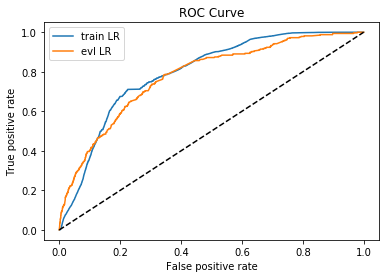

In [76]:
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(df_aff_ovsp[feature_lst],df_aff_ovsp['bad_ind'] )
    
y_pred = lr_model.predict_proba(df_aff_ovsp[feature_lst])[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(df_aff_ovsp['bad_ind'],y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)
    
y_pred = lr_model.predict_proba(evl_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(evl_y,y_pred)
evl_ks = abs(fpr_lr - tpr_lr).max()
print('evl_ks : ',evl_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

可以看到，最终跨时间验证集上，是有3.5个百分点的提升的。而训练集上提升了5个百分点，较为符合预期，过拟合的风险不是很大。

请同学们自行尝试其他算法进行样本筛选和其他采样方法。